In [76]:
import json
import pickle
import os
import zipfile

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from glob import glob
from shutil import copyfile

pd.options.mode.chained_assignment = None
sns.set_style("darkgrid")

In [77]:
#### Settings
### Learning Rate for CNN = 0.01, no learning rate decay

In [78]:
os.chdir("/home/bahy/research/icl-prelab-assignment/")

In [79]:
!pwd

/home/bahy/research/icl-prelab-assignment


In [80]:
datas = []
for file_name in glob("logs_q3/lr0.01/*.txt"):
    if "untitled" in file_name:
        continue
    print(file_name)
    file = open(file_name, "rb")
    for data in file.readlines():
        if len(data) < 10: # Ignoring blank space/not useful information
            continue
        dict_data = eval(data)
        dict_data['setting'] = file_name.split("/")[2].split("-")[0]
        dict_data['E'] = file_name.split("/")[2].split("-")[2].replace("E", "")
        dict_data['model'] = file_name.split("/")[2].split("-")[-1].split(".")[0]
 
        datas.append(dict_data)
        
datas = pd.DataFrame(datas)

logs_q3/lr0.01/IID-B600-E1-C0.1-MNIST-CNN.txt
logs_q3/lr0.01/NONIID-B10-E1-C0.1-MNIST-CNN.txt
logs_q3/lr0.01/IID-B600-E20-C0.1-MNIST-CNN.txt
logs_q3/lr0.01/NONIID-B50-E1-C0.1-MNIST-CNN.txt
logs_q3/lr0.01/IID-B10-E20-C0.1-MNIST-CNN.txt
logs_q3/lr0.01/IID-B50-E1-C0.1-MNIST-CNN.txt
logs_q3/lr0.01/IID-B50-E20-C0.1-MNIST-CNN.txt
logs_q3/lr0.01/NONIID-B50-E20-C0.1-MNIST-CNN.txt
logs_q3/lr0.01/NONIID-B600-E20-C0.1-MNIST-CNN.txt
logs_q3/lr0.01/NONIID-B600-E1-C0.1-MNIST-CNN.txt
logs_q3/lr0.01/IID-B10-E1-C0.1-MNIST-CNN.txt
logs_q3/lr0.01/NONIID-B10-E20-C0.1-MNIST-CNN.txt


In [81]:
datas.head()

,C,B,comm_round,train_acc,test_acc,train_loss,test_loss,learning_rate,setting,E,model
0,0.1,600.0,1,0.0985,0.1023,2.2986,2.2978,Undefined,IID,1,CNN
1,0.1,600.0,2,0.1060,0.1105,2.2952,2.2944,Undefined,IID,1,CNN
2,0.1,600.0,3,0.1142,0.1198,2.2919,2.2911,Undefined,IID,1,CNN
3,0.1,600.0,4,0.1220,0.1281,2.2887,2.2877,Undefined,IID,1,CNN
4,0.1,600.0,5,0.1294,0.1330,2.2854,2.2844,Undefined,IID,1,CNN


In [82]:
# Sort the data
ROUNDING_DIGIT = 4

df_metrics = datas.sort_values(by=['setting', 'B', 'E', 'comm_round']).reset_index(drop=True)
df_metrics = df_metrics[['setting', 'B', 'E', 'C', 'comm_round', 'train_acc', 'test_acc', 'train_loss', 'test_loss', 'model']]
df_metrics['train_acc'] = df_metrics['train_acc'].apply(lambda x: round(x, ROUNDING_DIGIT))
df_metrics['test_acc'] = df_metrics['test_acc'].apply(lambda x: round(x, ROUNDING_DIGIT))
df_metrics['train_loss'] = df_metrics['train_loss'].apply(lambda x: round(x, ROUNDING_DIGIT))
df_metrics['test_loss'] = df_metrics['test_loss'].apply(lambda x: round(x, ROUNDING_DIGIT))
df_metrics.head()

,setting,B,E,C,comm_round,train_acc,test_acc,train_loss,test_loss,model
0,IID,10.0,1,0.1,1,0.6006,0.6148,2.0736,2.0677,CNN
1,IID,10.0,1,0.1,2,0.7659,0.7795,1.3630,1.3437,CNN
2,IID,10.0,1,0.1,3,0.8295,0.8434,0.6980,0.6723,CNN
3,IID,10.0,1,0.1,4,0.8757,0.8815,0.4930,0.4735,CNN
4,IID,10.0,1,0.1,5,0.8888,0.8976,0.4061,0.3861,CNN


In [83]:
df_metrics.tail()

,setting,B,E,C,comm_round,train_acc,test_acc,train_loss,test_loss,model
16805,NONIID,600.0,20,0.1,996,0.8641,0.8676,0.3924,0.3817,CNN
16806,NONIID,600.0,20,0.1,997,0.8988,0.8990,0.2788,0.2746,CNN
16807,NONIID,600.0,20,0.1,998,0.9220,0.9256,0.2369,0.2273,CNN
16808,NONIID,600.0,20,0.1,999,0.9468,0.9502,0.1773,0.1652,CNN
16809,NONIID,600.0,20,0.1,1000,0.9456,0.9477,0.1773,0.1676,CNN


In [84]:
df_metrics['label'] = df_metrics['B'].apply(lambda x: "B=" + str(x)) + " " +\
                        df_metrics['E'].apply(lambda x: "E=" + str(x))
df_metrics.head()

,setting,B,E,C,comm_round,train_acc,test_acc,train_loss,test_loss,model,label
0,IID,10.0,1,0.1,1,0.6006,0.6148,2.0736,2.0677,CNN,B=10.0 E=1
1,IID,10.0,1,0.1,2,0.7659,0.7795,1.3630,1.3437,CNN,B=10.0 E=1
2,IID,10.0,1,0.1,3,0.8295,0.8434,0.6980,0.6723,CNN,B=10.0 E=1
3,IID,10.0,1,0.1,4,0.8757,0.8815,0.4930,0.4735,CNN,B=10.0 E=1
4,IID,10.0,1,0.1,5,0.8888,0.8976,0.4061,0.3861,CNN,B=10.0 E=1


In [85]:
df_metrics.groupby(["setting", "label"]).size()

setting  label       
IID      B=10.0 E=1      1000
         B=10.0 E=20     1000
         B=50.0 E=1      1742
         B=50.0 E=20     1042
         B=600.0 E=1     2665
         B=600.0 E=20    1361
NONIID   B=10.0 E=1      2000
         B=10.0 E=20     1000
         B=50.0 E=1      1000
         B=50.0 E=20     1000
         B=600.0 E=1     2000
         B=600.0 E=20    1000
dtype: int64

In [86]:
df_metrics.groupby(["setting", "label"])['test_acc'].max()

setting  label       
IID      B=10.0 E=1      0.9909
         B=10.0 E=20     0.9909
         B=50.0 E=1      0.9900
         B=50.0 E=20     0.9900
         B=600.0 E=1     0.9748
         B=600.0 E=20    0.9887
NONIID   B=10.0 E=1      0.9834
         B=10.0 E=20     0.9753
         B=50.0 E=1      0.9568
         B=50.0 E=20     0.9683
         B=600.0 E=1     0.9674
         B=600.0 E=20    0.9555
Name: test_acc, dtype: float64

In [37]:
def make_monotonic(input_df, metric):
    input_df = input_df.reset_index(drop=True)
    max_val = input_df[metric][0]
    keep = []
    
    for i in range(len(input_df)):
        current = input_df[metric][i]
        if max_val <= current:
            keep.append(input_df['comm_round'].index[i])
            max_val = current         
    
    return input_df.iloc[keep].reset_index(drop=True)

def fill_the_gap(input_df, round_to_achieve):
    if len(input_df) == round_to_achieve:
        return input_df
    
    initial_comm = input_df.tail(1)['comm_round'].values[0]
    for i in range(round_to_achieve - initial_comm):
        add_df = input_df.tail(1)
        add_df['comm_round'] = add_df['comm_round'] + 1
        input_df = input_df.append(add_df)
    
    return input_df.reset_index(drop=True)

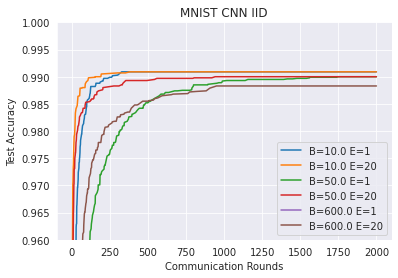

In [40]:
min_ylim = []
for combination in df_metrics['label'].unique():
    sample_df = df_metrics[(df_metrics['setting'] == "IID") & (df_metrics['label'] == combination)]
    sample_df = make_monotonic(sample_df, "test_acc")
    sample_df = fill_the_gap(sample_df, 2000)
    
    min_ylim.append(sample_df['test_acc'].min())
    sns.lineplot(data=sample_df, x='comm_round', y='test_acc', label=combination)

plt.ylim(0.96, 1)
plt.title("MNIST CNN IID")
plt.ylabel("Test Accuracy")
plt.xlabel("Communication Rounds")
plt.legend(loc='lower right')
plt.show()

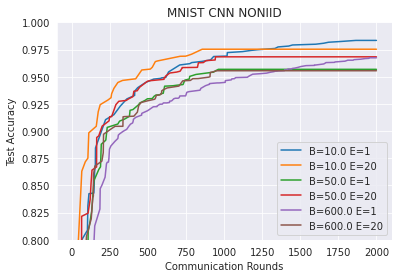

In [41]:
min_ylim = []
for combination in df_metrics['label'].unique():
    sample_df = df_metrics[(df_metrics['setting'] == "NONIID") & (df_metrics['label'] == combination)]
    sample_df = make_monotonic(sample_df, "test_acc")
    sample_df = fill_the_gap(sample_df, 2000)
    
    min_ylim.append(sample_df['test_acc'].min())
    sns.lineplot(data=sample_df, x='comm_round', y='test_acc', label=combination)

plt.ylim(0.8, 1)
plt.title("MNIST CNN NONIID")
plt.ylabel("Test Accuracy")
plt.xlabel("Communication Rounds")
plt.legend(loc='lower right')
plt.show()